In [9]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

import numdifftools as ndt # to comput the Hessian matrix

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}

sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Bayesian Hierarchical model

In order to obtain the MWC parameters given the fold-change measurements Manuel took at MBL and a credible region on such parameters we will use a Bayesian hierarchical model to fit each individual data-set.

## The MWC theory of LacI IPTG induction
Our theoretical model dictates that the fold change in gene expression is given by
\begin{equation}
    fc = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}
where $p_{act}(C)$ is given by
\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience. 

## Setting up the hierarchical model
Recalling that our objective is to infer the values of the dissociation constants $\mathbf{K} = (K_A, K_I)$ in the MWC model, let's think about the data that we have.

Our data consists of fold-change measurements done with different operators, different repressor copy numbers and different IPTG concentrations. On top of that we have multiple *biological replicas* performed in different days.

On the one hand, to find *the most representative parameters* for all the data we could simply **pool the data all together** and perform a global fit. But that simple act of pooling together the data implies strong assumptions. It assumes that the slight experimental/biological/paranormal differences are irrelevant and all the data was generated equally.

On the other hand we could take the other extreme point of view in which **each data-set is completely independent of the rest**. Fit a single parameter for each strain on each different day. But yet again this strategy implies different assumptions with their own caveats because if we believe in the theory the parameters should be in principle the same for all the strains and the biological replicas should be not very different from each other.

A *Bayesian hierarchical model* represents arguably the best of both worlds. In a hierarchical model each data set $d_i$ is assumed to have its own set of parameters $\mathbf{K}_i$ drawn from a distribution $P(\mathbf{K}_i \mid \mathbf{Q})$, where $\mathbf{Q} = (Q_A, Q_I)$ are the so-called *hyper-parameters*. One can think of the hyper-parameters as the most probable global parameter. On each experiment a set of parameters $\mathbf{K}$ is chosen from a distribution centered at these hyper-parameters.

I think (and that is part of the modeling decisions we need to make as scientists) that the most natural way of grouping the data is by single strain, single day with all IPTG concentrations. In other words we define as a "data set" the set of fold-changes measured for a single strain on a specific day. If we assume that the day-to-day variability and strian-to-strain variability gives small differences on th eparameters $\mathbf{K}$, we can model this variability by saying that the parameters for each data set are drawn out of a probability distribution
\begin{equation}
\mathbf{K} \sim P(\mathbf{K} \mid \mathbf{Q})
\end{equation}

Assuming this implies that we are set to find the set of parameters $\kappa = (\mathbf{K}_1, \mathbf{K}_2, \ldots)$ for each individual experiment, plus a hyper-parameter $\mathbf{Q} = (Q_A, Q_I)$.

By Bayes theorem this would imply that
\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto P(D \mid \kappa, \mathbf{Q}, I) \cdot P(\mathbf{Q}, \kappa \mid I)
\end{equation}.

A single data set $d_i \in D$ does not depend directly on the hyperparameters $\mathbf{Q}$, but only on th sample parameters $\mathbf{K}_i$. This implies that
\begin{equation}
P(D \mid \kappa, \mathbf{Q}, I) = \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I),
\end{equation}
where $n = \lvert D \rvert$ is the number of independent data sets.

The prior $P(\mathbf{Q}, \kappa \mid I)$ can be split into two terms using the definition of conditional probability
\begin{equation}
P(\mathbf{Q}, \kappa \mid I) = P(\kappa \mid \mathbf{Q}, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

Putting these terms together gives the posterior we would like to compute
\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I) \cdot P(\kappa \mid \mathbf{Q}, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

This posterior is in fat our **full hierarchical model**.

## Defining each of the terms

### The likelihood
For a single data set $d_i$ we have the following dpendent and independent variables:

**independent variables**
\begin{equation}
\left\{ R^{(i)}, \Delta\epsilon_r^{(i)}, \left[ C_1, C_2, \ldots, C_l \right] \right\},
\end{equation}
where $R_i$ is the number of repressors, $\Delta \epsilon_r$ is the binding energy and $C_i$ are the $l$ IPTG concentrations measured experimentally.

***dependent variables**
\begin{equation}
\left\{ \left[ fc_1, fc_2, \ldots, fc_l \right] \right\},
\end{equation}
the full set of fold-changes as measured with the flow cytometer.

If as before we were to assume the errors $(fc_{exp} - fc_{theory})$ are normally distributed I can think of 3 forms to handle the errors:
1. Global constant error $\sigma$ independent of IPTG concentration and strain
2. IPTG dependent error where we would have a set $\mathbf{\sigma} = (\sigma_1, \ldots, \sigma_l)$ for each of the IPTG concentrations used in the experiment.
3. IPTG and strain dependent error where we would have an error associated with each concentration of IPTG and with each strain (meaning each unique repressor copy number and binding energy)
\begin{bmatrix}
    \sigma_{11} & \sigma_{12} & \sigma_{13} & \dots  & \sigma_{1l} \\
    \sigma_{21} & \sigma_{22} & \sigma_{23} & \dots  & \sigma_{2l} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \sigma_{m1} & \sigma_{m2} & \sigma_{m3} & \dots  & \sigma_{ml}
\end{bmatrix}
where $m$ is the number of independent strains.

Let's first implement the simplest approach. We will assume we have a constant error over all concentrations and all strains. This means that we can write
\begin{equation}
P(d_i \mid \mathbf{K}_i, \sigma, I) = \left( 2 \pi \sigma^2 \right)^{-l / 2} \prod_{j = 1}^l \exp \left\{ - \frac{\left( fc_{exp}^{(ij)} -  fc_{thry}^{(ij)} \right)^2}{2 \sigma^2} \right\},
\end{equation}
where again $l$ is the number of IPTG concentrations, the superscript $(ij)$ indicates the $i$th data set and the $j$th IPTG concentration respectively and the $fc_{thry}^{(ij)} = fc\left(\epsilon_A^{(i)}, \epsilon_I^{(i)}, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(j)} \right)$ is the theoretical fold change given the set of indpedendent parameters.

### The probability $P(\mathbf{K} \mid \mathbf{Q}, I)$
For the probability $P(\mathbf{K} \mid \mathbf{Q}, I)$ we will assume a simple bivariate Gaussian centered at $\mathbf{Q}$, the hyper-parameter.
Again here we face a new modeling decision with respect to the error. From the analytical approach we saw that the parameters $\epsilon_A$ and $\epsilon_I$ are not independent. Therefore the bivariate Gaussian should include a covariance term $\sigma_{AI} = cov\left[ \epsilon_A, \epsilon_I \right] \neq 0$.
We will choose to include this term, therefore we will have
\begin{equation}
P(\mathbf{K}_i \mid \mathbf{Q}, \mathbf{\Sigma}, I) = \frac{1}{\sqrt{(2\pi)^2 \lvert \mathbf{\Sigma} \rvert}} \exp \left\{ -\frac{1}{2} (\mathbf{K}_i - \mathbf{Q})^T \mathbf{\Sigma}^{-1} (\mathbf{K}_i - \mathbf{Q}) \right\},
\end{equation}
where $\mathbf{\Sigma}$ is the covariance matrix
\begin{equation}
\mathbf{\Sigma} = \left[ \begin{array}{cc} \sigma_{A} & \sigma_{AI} \\ \sigma_{AI} & \sigma_{I} \end{array} \right],
\end{equation}
$\sigma_A$, and $\sigma_I$ are the standard deviations associated with the Gaussian distribution from which each data set samples their paramteres $\mathbf{K}_i $.

### The prior

We have come a long way from the original prior $P(\mathbf{Q} \mid I)$. We now have significantly many more parameters to fit for.
For simplicity we will assume that all the priors are indpendent, and given the nature of the variables we will assign to all of them a Jeffreys prior. Listing the parameters we have
\begin{equation}
P(\mathbf{Q}, \sigma, \sigma_A, \sigma_I, \sigma_{AI}) \propto \frac{1}{\epsilon_A} \cdot \frac{1}{\epsilon_I} \cdot \frac{1}{\sigma} \cdot \frac{1}{\sigma_A} \cdot \frac{1}{\sigma_I} \cdot \frac{1}{\sigma_{AI}}. 
\end{equation}

Time to put everything together!

Let's code up the functions to compute the theoretical fold-change

In [2]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, ea, ei, epsilon=4.5):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(ea))**2 / \
    ((1 + IPTG * np.exp(ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(ei))**2)
    return pact

def fold_change(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

Now let's code up the log posterior

In [3]:
def log_post(param, indep_var, dep_var):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        ]aram[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, 4.5, R, epsilon_r)
    
    # return the log posterior
    return -len(dep_var) / 2 * np.log(np.sum((dep_var - fc_theory)**2))

# Testing the functions with only 1 strain and one operator 

Now it is time to test this! But first let's read the data

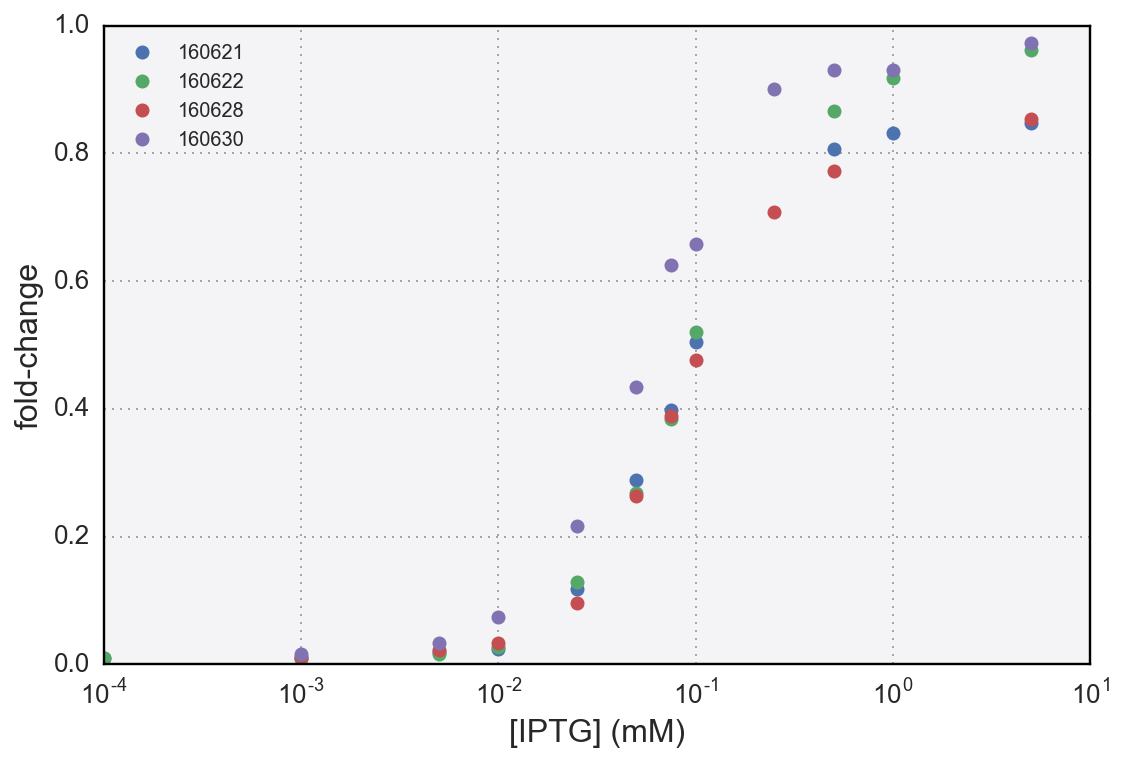

In [4]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

# Let's first try to do the regression using only one RBS and one operator
rbs = data[(data.strain=='1027') & (data.epsilon_r==-13.9)]

plt.figure()
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG, rbs[rbs.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

### Plotting the posterior distribution

Before computing the MAP and doing the proper regression, let's look at the posterior itself

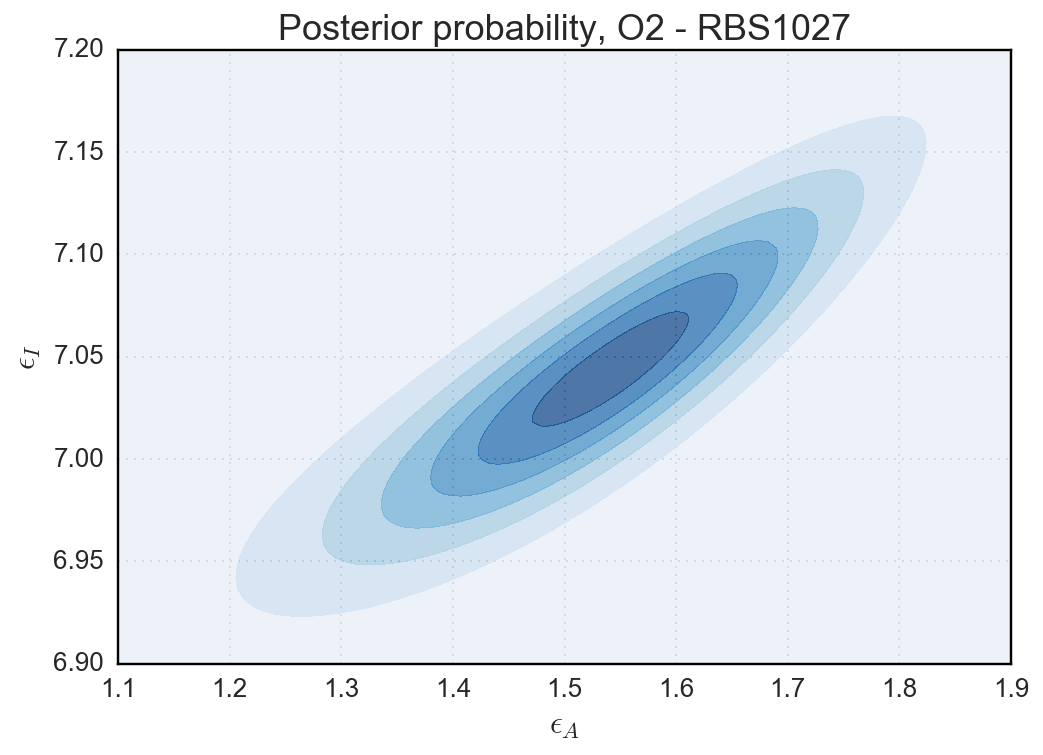

In [5]:
# Parameter values to plot
ea = np.linspace(1.1, 1.9, 100)
ei = np.linspace(6.9, 7.2, 100)

# make a grid to plot
ea_grid, ei_grid = np.meshgrid(ea, ei)

# compute the log posterior
indep_var = rbs[['IPTG', 'repressors', 'epsilon_r']]
dep_var = rbs.fold_change

log_posterior = np.empty_like(ea_grid)
for j in range(len(ea)):
    for i in range(len(ei)):
        log_posterior[i, j] = log_post([ea_grid[i, j], ei_grid[i, j]],
                                       indep_var.values, dep_var.values)

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(ea_grid, ei_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\epsilon_A$')
plt.ylabel(r'$\epsilon_I$')
plt.title('Posterior probability, O2 - RBS1027')

### Computing the MAP

In order to compute the Maximum a posteriori parameters or MAP for short we will use the `scipy.optimize.leastsq()` function.
For this we need to define a function that computes the residuals.

In [6]:
def resid(param, indep_var, dep_var):
    '''
    Residuals for the theoretical fold change.
    
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        ]aram[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    fold-change_exp - fold-change_theory
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, 4.5, R, epsilon_r)
    
    # return the log posterior
    return dep_var - fc_theory

To find the most likely parameters we need to provide an initial guess. The optimization routine only finds a local maximum and is not in general guaranteed to converge. Therefore, the initial guess can be very important.

After that we will be ready to use `scipy.optimize.leastsq()` to compute the MAP. We uses the args kwarg to pass in the other arguments to the resid() function. In our case, these arguments are the data points. The `leastsq()` function returns multiple values, but the first, the optimal parameter values (the MAP), is all we are interested in.

In [7]:
# Initial guess
p0 = np.array([1, 7]) # From plotting the posterior

# Extra arguments given as tuple 
args = (indep_var.values, dep_var.values)

# Compute the MAP 
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
ea, ei = popt

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} mM
Ki = {1:.5f} mM
""".format(np.exp(-ea), np.exp(-ei)))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 0.21 mM
Ki = 0.00087 mM



Just to show that these parameters indeed give a good fit let's plot the theory and the data

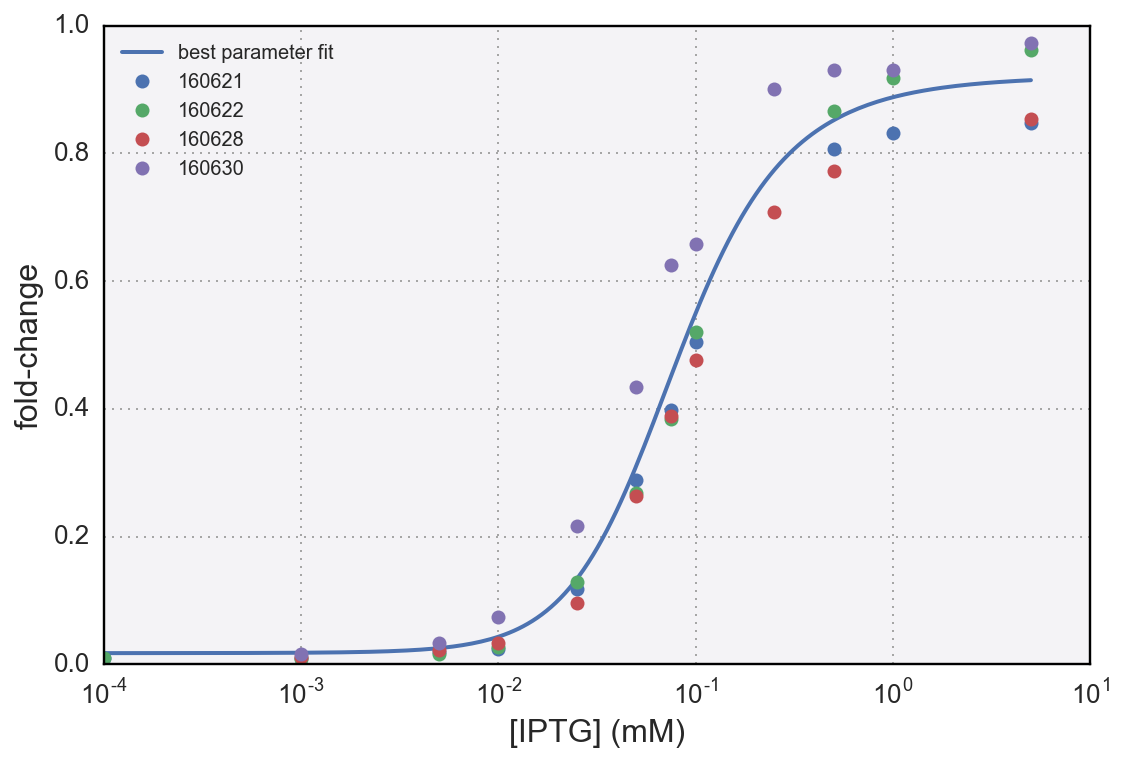

In [8]:
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = fold_change(IPTG, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG, rbs[rbs.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

# Computing error bars on the parameters.

In order to get a **credible region** on our parameter estimate we will use an aproximation in which the posterior probability can be represented as a Gaussian distribution. This approximation can be justified as a truncated Taylor expansion as follows:
Given our log posterior distribution with parameters $\mathbf{\epsilon} = (\epsilon_A, \epsilon_I)$ we can perform a Taylor expansion around our MAP $\epsilon^*$
\begin{equation}
\ln P(\mathbf{\epsilon} \mid D, I) \approx \text{constant} + \frac{1}{2} \left(  \mathbf{\epsilon - \epsilon^*}\right)^T \cdot H \cdot \left(\mathbf{\epsilon - \epsilon^*}\right),
\end{equation}
where $H$ is the symmetric **Hessian matrix** whose entries are given by the second derivatives, i.e.
\begin{equation}
H_{ij} = \frac{\partial ^2 \ln P(\mathbf{\epsilon} \mid D, I)}{\partial \epsilon_i \partial \epsilon_j} \biggr\rvert_{\mathbf{\epsilon} = \mathbf{\epsilon^*}}.
\end{equation}

If we exponentiate this truncated expansion to remove the log we find something that remarkably resembles a multivariate Gaussian distribution
\begin{equation}
P(\mathbf{\epsilon} \mid D, I) \approx \text{constant} \cdot \exp \left[ \frac{1}{2} \left( \mathbf{\epsilon} - \mathbf{\epsilon^*} \right)^T \cdot H \cdot \left( \mathbf{\epsilon} - \mathbf{\epsilon^*} \right) \right].
\end{equation}

From this we can see that the Hessian matrix plays the role of the negative inverse **covariance matrix**. As a matter of fact since the second derivatives are evaluated at the MAP the Hessian is *positive definite* and therefore this matrix can be inverted, obtaining our desired covariance matrix. So if we compute the Hessian at the MAP, and then invert this matrix, the diagonal terms of this inverted matrix will be the error bars for our parameters under this Gaussian approximation of the posterior!

Let's now compute the covariance matrix. For this we will numerically compute the Hessian using the `numdifftools` package. We first have to initialize a `ndt.Hessian` object and then indicate where to evaluate the second derivatives.

In [13]:
# Instantiate a numdifftools Hessian object for the log posterior
hes_fun = ndt.Hessian(log_post)

# Compute the Hessian at the map
hes = hes_fun(popt, indep_var.values, dep_var.values)

hes

array([[ -175.47733976,   378.15916556],
       [  378.15916556, -1080.26060224]])

Now that we computed the Hessian let's compute the negative inverse to get our precious covariance matrix!

In [14]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes) 

cov

array([[ 0.02320302,  0.00812252],
       [ 0.00812252,  0.00376909]])

Again the diagonal terms of this matrix give the approximate variance in the regression parameters. The offdiagonal terms give the covariance, which describe how parameters relate to each other. From the plot of the posterior previously we saw that there is definitely a positive correlation between the parameters, and that is reflected by non-zero entries in these offdiagonal terms.

But recall that this is giving the error bar on $\epsilon_A$ and $\epsilon_I$, not the dissociation constants themselves. Therefore we must "propagate the error" properly by doing the proper change of variables.
For this we use the approximation that if the error on $\epsilon_A$ is given by $\delta \epsilon_A$, we can use this relationship to compute $\delta K_A$, the error on the dissociation constant.

First we know the relationshipt between $\epsilon_A$ and $K_A$ is
\begin{equation}
\epsilon_A = - \ln K_A.
\end{equation}
Differenciating both sides we obtain
\begin{equation}
\delta \epsilon_A = - \frac{1}{K_A} \delta K_A.
\end{equation}
We now squre both sides and take the expected value
\begin{equation}
\langle \delta \epsilon_A \rangle^2 = \frac{\langle \delta K_A\rangle^2}{K_A^2}.
\end{equation}
Finally we re-arrange terms to find that the error bar on the dissociation constant is given by
\begin{equation}
\delta K_A = \sqrt{\langle \delta K_A \rangle^2} = \sqrt{\langle \delta \epsilon_A \rangle^2 \cdot K_A^2} = \delta \epsilon_A \cdot K_A
\end{equation}

Now let's report the parameter values with the proper error bars!

In [27]:
# Get the values for the dissociation constants and their respective error bars
Ka = np.exp(-ea)
Ki = np.exp(-ei)
deltaKa = np.sqrt(cov[0,0]) * Ka
deltaKi = np.sqrt(cov[1,1]) * Ki

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +- {1:0.3f} mM
Ki = {2:.5f} +- {3:0.6f} mM
""".format(Ka, deltaKa, Ki, deltaKi))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 0.21 +- 0.033 mM
Ki = 0.00087 +- 0.000054 mM



### Using the parameters to predict other strains

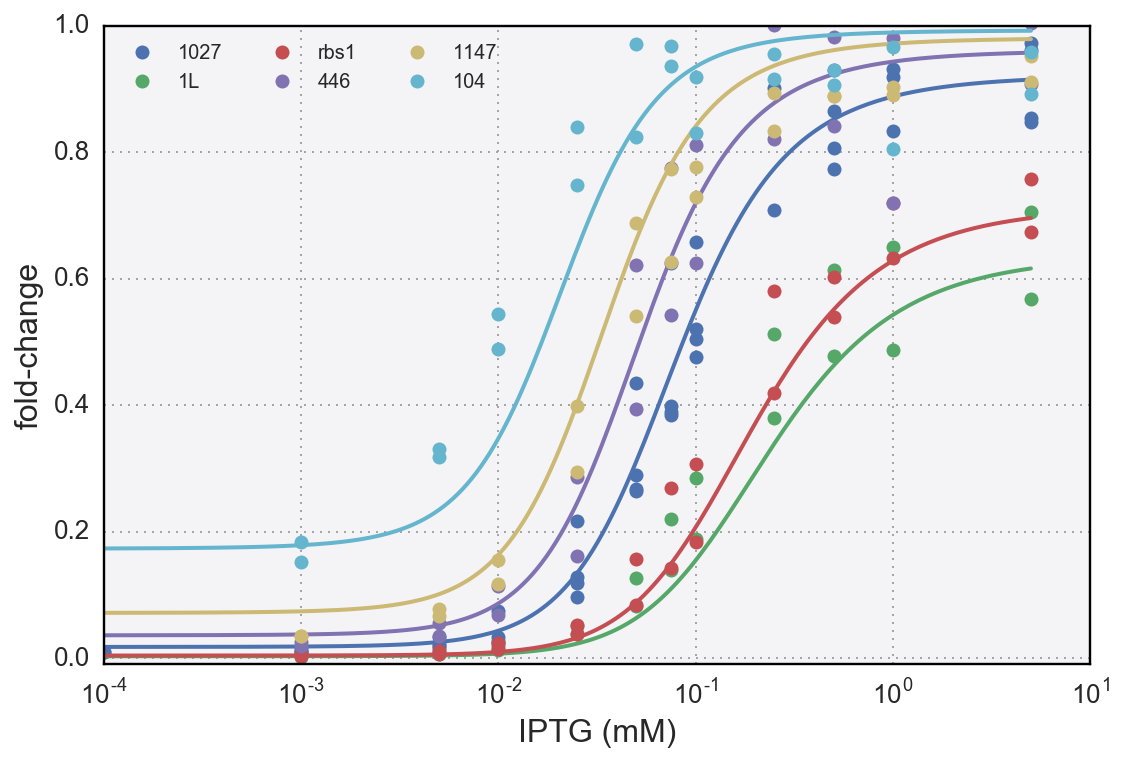

In [30]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

df_O2 = data.groupby('epsilon_r').get_group(-13.9)
plt.figure()
for i, strain in enumerate(df_O2[(df_O2.strain!='auto') & \
        (df_O2.strain!='delta')].strain.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, fold_change(IPTG, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O2[(df_O2.strain == strain)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot the experimental data
    plt.plot(df_O2[df_O2.strain == strain].sort_values(by='IPTG').IPTG, 
            df_O2[df_O2.strain == strain].sort_values(by='IPTG').fold_change, 
            marker='o', linewidth=0, label=strain, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (mM)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1])
plt.legend(loc=0, ncol=3)
plt.tight_layout()


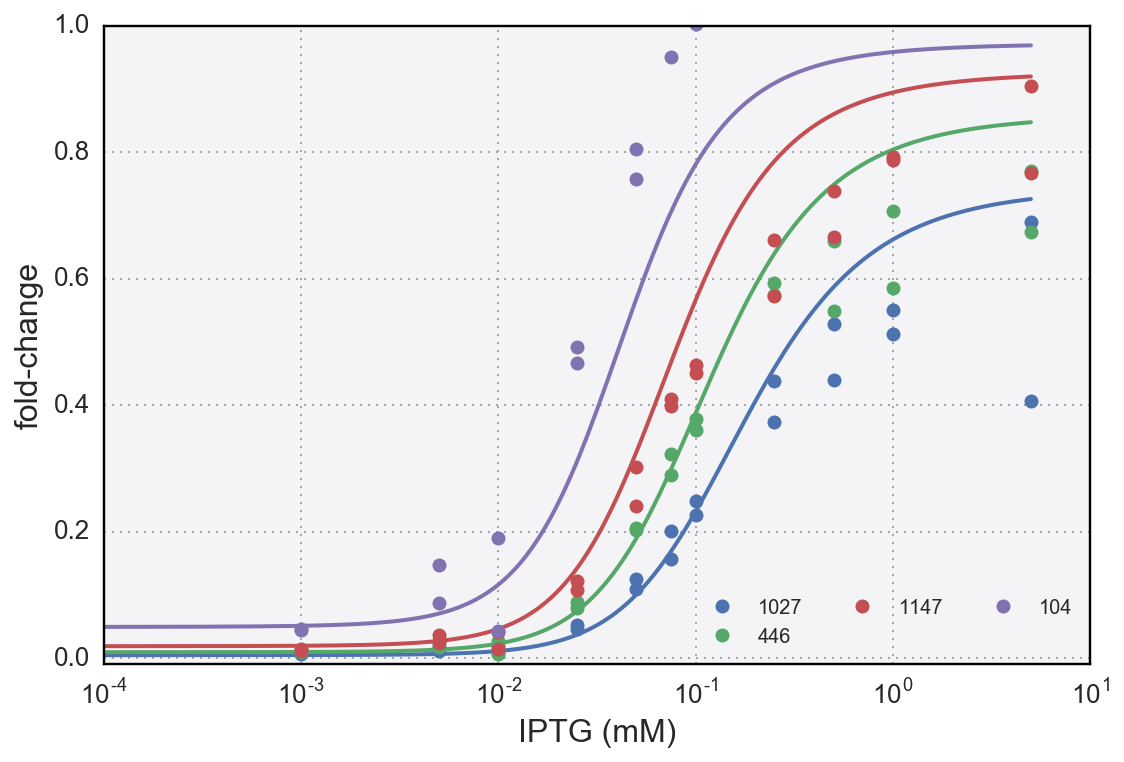

In [31]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

df_O1 = data.groupby('epsilon_r').get_group(-15.3)
plt.figure()
for i, strain in enumerate(df_O1[(df_O1.strain!='auto') & \
        (df_O1.strain!='delta')].strain.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, fold_change(IPTG, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O1[(df_O1.strain == strain)].repressors.unique(),
        epsilon_r=-15.3),
        color=colors[i])
    # plot the experimental data
    plt.plot(df_O1[df_O1.strain == strain].sort_values(by='IPTG').IPTG, 
            df_O1[df_O1.strain == strain].sort_values(by='IPTG').fold_change, 
            marker='o', linewidth=0, label=strain, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (mM)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1])
plt.legend(loc=0, ncol=3)
plt.tight_layout()
